목적: 틱톡 플랫폼의 동영상에서 오해의 소지가 있는 정보를 줄이는 것.

목표: 동영상 내에 클레임을 포함하는지, 단지 의견을 제시하는 건지 구분하여 예측한다.

1. 데이터 로드 및 탐색
2. Feature engineering
3. 데이터셋 분리
4. 텍스트 데이터 분석
5. 모델 구축
6. 모델 평가

In [2]:
import pandas as pd 
import numpy as np

# 시각화 및 한글 깨짐 방지
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'NanumGothic'

# 텍스트 데이터 분석
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [3]:
# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]
font_list

['DejaVu Sans Mono',
 'STIXNonUnicode',
 'cmtt10',
 'STIXGeneral',
 'STIXSizeThreeSym',
 'DejaVu Sans',
 'STIXNonUnicode',
 'STIXGeneral',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'STIXSizeFiveSym',
 'DejaVu Sans',
 'STIXSizeTwoSym',
 'STIXSizeOneSym',
 'cmss10',
 'STIXSizeFourSym',
 'STIXNonUnicode',
 'cmmi10',
 'STIXSizeTwoSym',
 'DejaVu Sans Display',
 'DejaVu Serif',
 'cmr10',
 'cmsy10',
 'DejaVu Serif',
 'DejaVu Serif Display',
 'STIXSizeFourSym',
 'STIXGeneral',
 'STIXNonUnicode',
 'STIXSizeOneSym',
 'STIXSizeThreeSym',
 'DejaVu Sans Mono',
 'DejaVu Sans',
 'DejaVu Serif',
 'cmb10',
 'DejaVu Sans Mono',
 'STIXGeneral',
 'cmex10',
 'DejaVu Sans',
 'Tempus Sans ITC',
 'NewJumja',
 'Wide Latin',
 'Niagara Solid',
 'Verdana',
 'Nirmala UI',
 'Consolas',
 'Copperplate Gothic Light',
 'Lucida Sans Typewriter',
 'MoeumT R',
 'Hancom Hoonminjeongeum_V',
 'Segoe UI',
 'Sitka Small',
 'FZShuTi',
 'YouYuan',
 'MingLiU-ExtB',
 'Segoe UI',
 'Myanmar Text',
 'Perpetua',
 'Segoe MDL2 Assets',
 'H

# 1. 데이터 로드 및 탐색

In [4]:
data = pd.read_csv("tiktok_dataset.csv") 

In [5]:
data.shape

(19382, 12)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [7]:
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [8]:
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [9]:
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [10]:
#결측치 제거
data = data.dropna(axis=0)
data.duplicated().sum()


# 트리 기반 모형은 이상치에 강하므로, 이상치는 꼭 삭제해야만 하는 것은 아니다.

0

In [11]:
#타켓 클래스 균형 확인 -> 전처리 필요 없음
data["claim_status"].value_counts(normalize=True)

claim      0.503458
opinion    0.496542
Name: claim_status, dtype: float64

# 2. Feature engineering

In [12]:
# 텍스트 길이 컬럼 생성
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


In [13]:
data[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


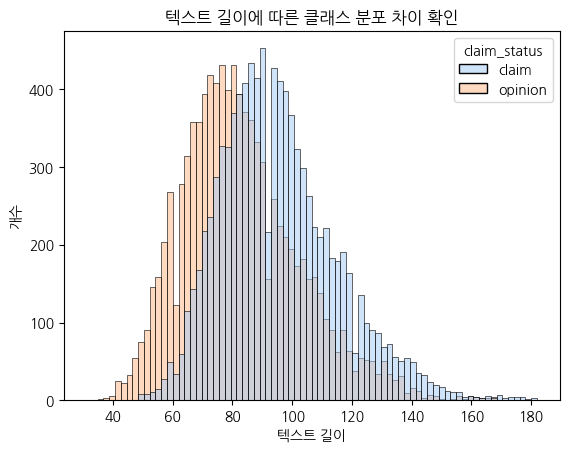

In [14]:
sns.histplot(data=data, stat="count", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("텍스트 길이")
plt.ylabel("개수")
plt.title("텍스트 길이에 따른 클래스 분포 차이 확인")
plt.show()

In [15]:
# Feature selection and transformation

X = data.copy()
X = X.drop(['#', 'video_id'], axis=1)

# 타겟 컬럼 인코딩
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})

# 카테고리 변수 인코딩
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)

X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


# 3. 데이터셋 분리

In [16]:
y = X['claim_status'] 

In [17]:
X = X.drop(['claim_status'], axis=1)

In [18]:
#테스트셋 분리
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [19]:
# 트레이닝 : 밸리데이션 : 테스트 = 6 : 2 : 2
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

In [20]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

# 4. 텍스트 데이터 분석

In [21]:
# CountVectorizer 객체 생성 - 텍스트에 등장한 단어 수를 기반으로 문서 분류, 키워드 추출 등에 활용
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec 

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [22]:
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [23]:
# 배열을 데이터프레임화
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
# 기존 텍스트 컬럼 제거 후 새로 만든 데이터프레임 연결
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,134,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,97,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,76,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,58,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,57,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# 밸리데이션 셋에도 적용
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,72,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,96,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,88,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,83,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,104,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [48]:
# 테스트 셋에도 적용
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,107,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,69,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,90,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,76,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,72,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 5. 모델 구축

## - 랜덤포레스트 모델

In [29]:
# 랜덤포레스트 분류기 생성
rf = RandomForestClassifier(random_state=23) 

# GridSearchCV 위한 파라미터 딕셔너리
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

scoring = {'accuracy', 'precision', 'recall', 'f1'}

# GridSearchCV 객체 생성
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [30]:
%%time
rf_cv.fit(X_train_final, y_train)

CPU times: total: 15min 42s
Wall time: 15min 47s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=23),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring={'precision', 'f1', 'accuracy', 'recall'})

In [31]:
# recall 0.995 -> 거의 전부 다 제대로 예측했다고 볼 수 있다.
rf_cv.best_score_

0.9953408110440034

In [32]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

## - XGBoost 모델

In [33]:
# XGBoost 분류기 초기화
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# GridSearchCV 위한 파라미터 딕셔너리
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

scoring = {'accuracy', 'precision', 'recall', 'f1'}

# GridSearchCV 객체 생성
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall') 

In [34]:
%%time
xgb_cv.fit(X_train_final, y_train)

CPU times: total: 45min 9s
Wall time: 6min 29s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring={'precision', 'f1', 'accuracy', 'recall'})

In [35]:
xgb_cv.best_score_

0.9906808769992594

In [36]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

# 6. 모델 평가

## - 랜덤포레스트 모델

In [37]:
y_pred = rf_cv.best_estimator_.predict(X_val_final)
y_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [38]:
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

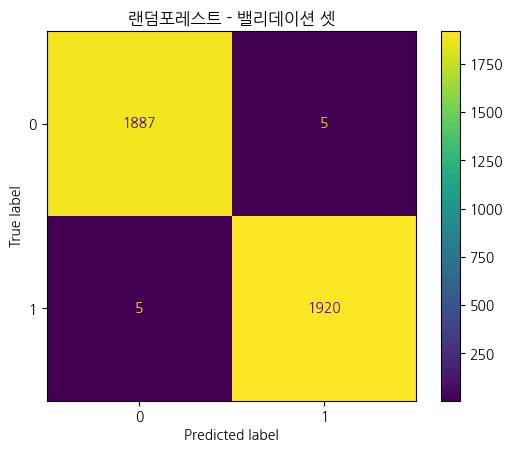

In [41]:
# Confusion matrix 계산
log_cm = confusion_matrix(y_val, y_pred)

# Confusion matrix 시각화
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

log_disp.plot()

plt.title('랜덤포레스트 - 밸리데이션 셋')

plt.show()

In [42]:
# Classification report 생성
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



## - XGBoost 모델 생성

In [43]:
y_pred = xgb_cv.best_estimator_.predict(X_val_final)
y_pred

array([1, 0, 1, ..., 1, 1, 1])

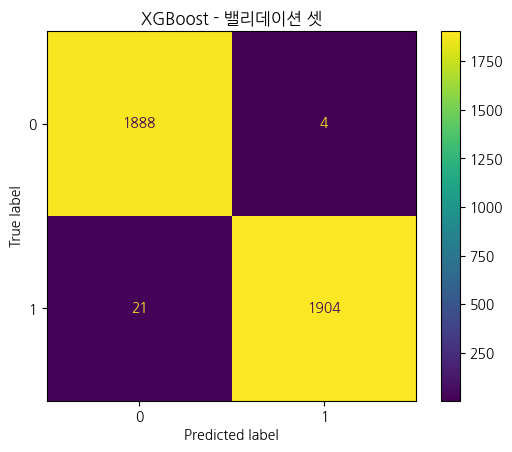

In [45]:
# Confusion matrix 계산
log_cm = confusion_matrix(y_val, y_pred)

# Confusion matrix 시각화
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

log_disp.plot()

plt.title('XGBoost - 밸리데이션 셋')

plt.show()

In [46]:
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



두 모델을 비교했을 때, 랜덤포레스트 모델이 XGBoost 모델보다 높은 Recall 점수(낮은 False Negative)를 보였으므로,<br>

<b>최종 예측 모델로 랜덤포레스트를 사용한다.</b>

In [49]:
y_pred = rf_cv.best_estimator_.predict(X_test_final) 

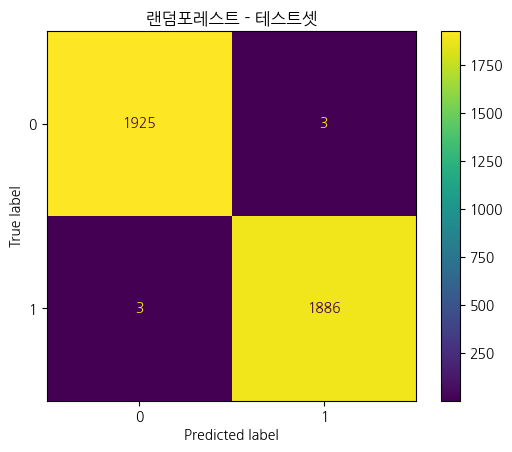

In [50]:
log_cm = confusion_matrix(y_test, y_pred)

log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

log_disp.plot()

plt.title('랜덤포레스트 - 테스트셋')

plt.show()

In [52]:
target_labels = ['opinion', 'claim']
print(classification_report(y_test, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1928
       claim       1.00      1.00      1.00      1889

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



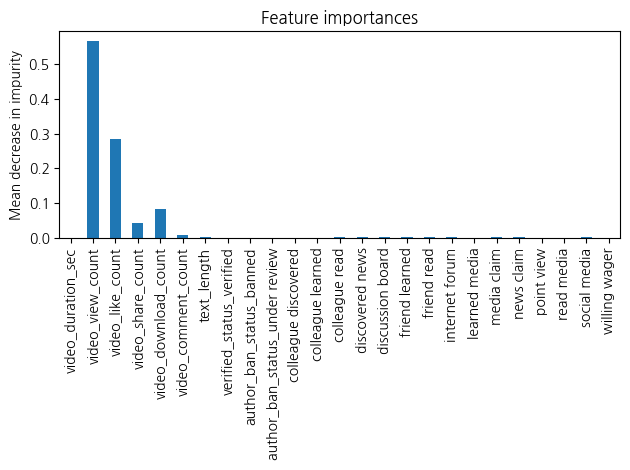

In [51]:
# Feature Importances 확인

importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()